In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import functions as myTSEB
from sklearn.tree import DecisionTreeClassifier, export_text

In [10]:
path = rf'files/inputs_sensitivity_analysis_CN_R.csv'

data = pd.read_csv(path)
K_be = myTSEB.estimate_Kbe(data.x_LAD, 0)
fv02 = np.clip((1 - np.exp(-K_be * data.LAI)) * data.difffv, 0, 1)
data.loc[:, 'fv'] = fv02
data.loc[:, 'Trad'] = data.Tair + data.diffTrad


In [26]:
names = data.columns[1:-6]
Xfeat = data[names].values
y = data["flag"].astype(int).values

clf = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=0
)
clf.fit(Xfeat, y)

print(export_text(clf, feature_names=names))

|--- LAI <= 1.26
|   |--- u <= 3.25
|   |   |--- sza_degrees <= 56.85
|   |   |   |--- leaf_width <= 0.02
|   |   |   |   |--- class: 0
|   |   |   |--- leaf_width >  0.02
|   |   |   |   |--- class: 32
|   |   |--- sza_degrees >  56.85
|   |   |   |--- u <= 0.67
|   |   |   |   |--- class: 32
|   |   |   |--- u >  0.67
|   |   |   |   |--- class: 0
|   |--- u >  3.25
|   |   |--- h_V <= 1.38
|   |   |   |--- sza_degrees <= 50.02
|   |   |   |   |--- class: 32
|   |   |   |--- sza_degrees >  50.02
|   |   |   |   |--- class: 0
|   |   |--- h_V >  1.38
|   |   |   |--- diffTrad <= 7.30
|   |   |   |   |--- class: 0
|   |   |   |--- diffTrad >  7.30
|   |   |   |   |--- class: 128
|--- LAI >  1.26
|   |--- diffTrad <= 5.25
|   |   |--- LAI <= 5.14
|   |   |   |--- saa_degrees <= 322.56
|   |   |   |   |--- class: 0
|   |   |   |--- saa_degrees >  322.56
|   |   |   |   |--- class: 1
|   |   |--- LAI >  5.14
|   |   |   |--- sza_degrees <= 50.43
|   |   |   |   |--- class: 0
|   |   |   |

In [28]:
classes, counts = np.unique(y, return_counts=True)
classes, counts
# print("Tree classes:", clf.classes_)

(array([  0,   1,   2,  32, 128]), array([21302,   320,   381,   703,  3294]))

In [18]:
import pandas as pd
from sklearn.tree import _tree

def tree_to_table(clf, feature_names):
    tree = clf.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree.feature
    ]

    rows = []

    def recurse(node, conditions):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]

            recurse(
                tree.children_left[node],
                conditions + [f"{name} <= {threshold:.2f}"]
            )
            recurse(
                tree.children_right[node],
                conditions + [f"{name} > {threshold:.2f}"]
            )
        else:
            rows.append({
                "rule": " AND ".join(conditions),
                "class": int(tree.value[node].argmax()),
                "samples": int(tree.n_node_samples[node])
            })

    recurse(0, [])
    return pd.DataFrame(rows)

In [20]:
rules_df = tree_to_table(clf, names)
rules_df

,rule,class,samples
0,diffTrad <= 5.90 AND LAI <= 0.65,0,340
1,diffTrad <= 5.90 AND LAI > 0.65 AND u <= 0.38 ...,0,274
2,diffTrad <= 5.90 AND LAI > 0.65 AND u <= 0.38 ...,0,394
3,diffTrad <= 5.90 AND LAI > 0.65 AND u > 0.38 A...,0,14762
4,diffTrad <= 5.90 AND LAI > 0.65 AND u > 0.38 A...,0,1362
5,diffTrad > 5.90 AND u <= 3.09 AND LAI <= 0.77,3,228
6,diffTrad > 5.90 AND u <= 3.09 AND LAI > 0.77 A...,0,3307
7,diffTrad > 5.90 AND u <= 3.09 AND LAI > 0.77 A...,0,1798
8,diffTrad > 5.90 AND u > 3.09 AND LAI <= 2.65 A...,0,698
9,diffTrad > 5.90 AND u > 3.09 AND LAI <= 2.65 A...,4,308


In [21]:
from sklearn.tree import DecisionTreeClassifier, export_text

names = data.columns[1:-5]
Xfeat = data[names].values
y = data["error"].astype(int).values  # 1 = failure (neg_total or nan)

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=200, random_state=0)
clf.fit(Xfeat, y)

print(export_text(clf, feature_names=names))

KeyError: 'error'

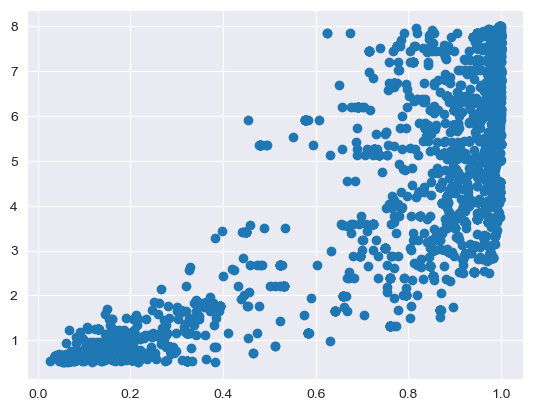

In [25]:
plt.scatter(data=data_eq0, x="f_theta", y='LAI')